In [1]:
# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

In this notebook, I will be performing very brief EDA and creating a work plan for the project. The goal is to forecast the churn of clients - specifically, determining when a particular client is about to leave so that they can be offered discounts and whatnot to discourage their exit. I will be loading in the data and checking it out, then ultimately training a machine learning model to estimate when a user will churn. AUC-ROC will be the primary metric and must be greater than 0.75, and accuracy will also be noted. I will perform the brunt of the preprocessing and EDA after the work plan has been submitted.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
contract = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=['BeginDate', 'EndDate'], infer_datetime_format=True)

Let's look at each table individually. I'll look for missing/duplicate values and check datatypes, and rather than fixing these issues right away like usual, I will include these fixes in my plan as part of preprocessing. I'll also make note of feature engineering ideas.

# First Look

## Phone

In [4]:
phone.info()
phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [5]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8544-GOQSH,No
freq,1,3390


In [6]:
phone.duplicated().sum()

0

In [7]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [8]:
# Testing this function
!pip install inflection
from inflection import underscore
underscore('CamelCase')

'camel_case'

The dataset looks good, but the MultipleLines column should be Boolean. I will use the inflection.underscore function to change column names from camel case to snake case. I can join this phone data onto the eventual master dataset.

## Personal

In [9]:
personal.info()
personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [10]:
personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,8544-GOQSH,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [11]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [12]:
personal.duplicated().sum()

0

The columns aside from the ID column should be Boolean. I'll change column names to snake case. The data looks good otherwise. I can again join tables on the customerID column.

## Internet

In [13]:
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [14]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8544-GOQSH,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [15]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [16]:
internet.duplicated().sum()

0

Again, column names need changed and the data can be Boolean. InternetService can be categorical. There is some overlap between services provided - online security and device protection both involve internet security, so a new column could be created where a 1 indicates that a user has at least one of these. The same strategy goes for streaming TV and streaming movies.

## Contract

In [17]:
contract.info()
contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [18]:
contract.describe(include='all', datetime_is_numeric=True)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,NaN,5,3,2,4,NaN,6531
top,8544-GOQSH,NaN,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,NaN,5174,3875,4171,2365,NaN,11
mean,NaN,2017-04-30 13:01:50.918642688,NaN,NaN,NaN,NaN,64.761692,NaN
min,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,2015-06-01 00:00:00,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,2017-09-01 00:00:00,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,2019-04-01 00:00:00,NaN,NaN,NaN,NaN,89.850000,NaN
max,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,118.750000,NaN


Looking at the EndDate stats - 5174 out of 7043 have not churned, which indicates a substantial class imbalance. I'll balance the classes by oversampling the churned users so as to preserve valuable data.

In [19]:
contract.duplicated().sum()

0

In [20]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Change PaperlessBilling to Boolean - Type and PaymentMethod to categorical - TotalCharges to float (probably requires eliminating some non-numerical values). Creating a target column from EndDate that is a Boolean may be a good idea. The dates can be turned to datetime format - the month, year, day, and hour that the customer joined may be useful, and I certainly think the length of their subscription would be key. I need to get the "present" datetime (Feb 1, 2020) and find the difference for customers who have not yet churned; for customers who have churned, I can just find the difference between their churn date and beginning dates.

# Clarifying questions

- Can we assume that the latest date (Feb 1, 2020) is the "present"?
- Should I prioritize the minimization of type I or type II errors, or only look at general AUC-ROC?
    - i.e. Would you rather wrongly predict a customer churning or staying?

# Rough Plan

1. Loading and preprocessing
    - Load csv data into DataFrames
    - Change column names to snake case
    - Update datatypes to correct types
    - Join tables into master dataframe
2. Feature Engineering
    - Combine redundant features
    - Create Boolean target column from churn data
    - Extract specific date information from BeginDate data and find length of tenure
3. Exploratory Data Analysis
    - Look for correlation amongst features
    - Look for correlation between features and target
4. Try machine learning models
    - Split dataset into train/validate/test sets, while balancing classes
    - Further preprocess dataset based on each model's requirements (OHE vs ordinal encoding)
    - Use logistic regression model as sanity check
    - Try gradient boosting, random forest, and another type of model
5. Test final model
    - Test the best performing model on the test set
    - Report tested AUC-ROC and accuracy scores
    - Draw conclusions

# 1. Loading and preprocessing

## Load data

Data is already loaded above.

## Change column names

In [21]:
from inflection import underscore
phone.columns = [underscore(x) for x in phone.columns]
internet.columns = [underscore(x) for x in internet.columns]
personal.columns = [underscore(x) for x in personal.columns]
contract.columns = [underscore(x) for x in contract.columns]

In [22]:
# Verifying success
print(phone.columns)
print(internet.columns)
print(personal.columns)
print(contract.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


All column names look great.

## Update datatypes

### Phone

In [23]:
phone.info()
phone.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,8544-GOQSH,No
freq,1,3390


In [24]:
def to_bool(df, names):
#     Will update Yes/No to 1/0
    for name in names:
        df[name] = df[name].map({'Yes':1, 'No':0}).astype('int8')
    return df

In [25]:
phone = to_bool(phone, ['multiple_lines'])

### Personal

In [26]:
personal.info()
personal.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,8544-GOQSH,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [27]:
personal = to_bool(personal, ['partner', 'dependents'])
personal.senior_citizen = personal.senior_citizen.astype('int8')
personal.gender = personal.gender.astype('category')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     7043 non-null   object  
 1   gender          7043 non-null   category
 2   senior_citizen  7043 non-null   int8    
 3   partner         7043 non-null   int8    
 4   dependents      7043 non-null   int8    
dtypes: category(1), int8(3), object(1)
memory usage: 82.8+ KB


### Internet

In [28]:
internet.info()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8544-GOQSH,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [29]:
internet.internet_service = internet.internet_service.astype("category")
internet = to_bool(internet, ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'])
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        5517 non-null   object  
 1   internet_service   5517 non-null   category
 2   online_security    5517 non-null   int8    
 3   online_backup      5517 non-null   int8    
 4   device_protection  5517 non-null   int8    
 5   tech_support       5517 non-null   int8    
 6   streaming_tv       5517 non-null   int8    
 7   streaming_movies   5517 non-null   int8    
dtypes: category(1), int8(6), object(1)
memory usage: 81.1+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


### Contract

In [30]:
contract.info()
contract.describe(include='all', datetime_is_numeric=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,NaN,5,3,2,4,NaN,6531
top,8544-GOQSH,NaN,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,NaN,5174,3875,4171,2365,NaN,11
mean,NaN,2017-04-30 13:01:50.918642688,NaN,NaN,NaN,NaN,64.761692,NaN
min,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,2015-06-01 00:00:00,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,2017-09-01 00:00:00,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,2019-04-01 00:00:00,NaN,NaN,NaN,NaN,89.850000,NaN
max,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,118.750000,NaN


In [31]:
contract[['type', 'payment_method']] = contract[['type', 'payment_method']].astype('category')
contract = to_bool(contract, ['paperless_billing'])
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int8          
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(1), int8(1), object(3)
memory usage: 296.2+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65


In [32]:
contract['total_charges'] = pd.to_numeric(contract.total_charges, errors='coerce')
contract.total_charges.isna().sum()

11

Let's investigate missing values in the total charges column.

In [33]:
contract[contract.total_charges.isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,NaN


Ah, all NaN total charges are instances where the user signed up "today". Let's make these zeros and preserve the data.

In [34]:
contract.total_charges = contract.total_charges.fillna(0)

In [35]:
contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [36]:
contract.end_date = pd.to_datetime(contract.end_date.replace('No', np.NaN))

In [37]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int8          
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: category(2), datetime64[ns](2), float64(2), int8(1), object(1)
memory usage: 296.2+ KB


## Join tables

Let's start off with the contracts table, which contains the target, and then left join the other tables onto this one.

In [38]:
df = pd.merge(contract, phone, how='left', on='customer_id')
df = pd.merge(df, internet, how='left', on='customer_id')
df = pd.merge(df, personal, how='left', on='customer_id')

In [39]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int8          
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   multiple_lines     6361 non-null   float64       
 9   internet_service   5517 non-null   category      
 10  online_security    5517 non-null   float64       
 11  online_backup      5517 non-null   float64       
 12  device_protection  5517 non-null   float64       
 13  tech_support       5517 non-null   float64       
 14  streamin

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,NaN,DSL,0.0,1.0,0.0,0.0,0.0,0.0,Female,0,1,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0.0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,Male,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,0.0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,Male,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,DSL,1.0,0.0,1.0,1.0,0.0,0.0,Male,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,Female,0,0,0


Looks like I should have merged dataframes and then dealt with missing values. Let's touch everything up. I'm still ok with end_date having NaNs. Most of the other columns that contain NaNs are Boolean values. I'll just replace NaNs with False Bools. For internet_service I'll replace NaNs with "None".

In [40]:
# df[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']] = \
# df[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']].fillna(0).astype('int8')

In [42]:
def update_values(df, columns):
    for col in columns:
        df[col] = pd.Series(['yes' if i==1 else 'no' if i==0 else 'no internet' for i in df[col]]).astype('category')
    return df
columns = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df = update_values(df, columns)

In [43]:
df.internet_service = df.internet_service.astype('object').fillna("None").astype('category')

I'm happy with the preprocessing.

# 2. Feature engineering

## Combine redundant features

In [41]:
df['phone_service'] = pd.Series(['multiple' if i==1 else 'single' if i==0 else 'none' for i in df.multiple_lines]).astype('category')
df = df.drop('multiple_lines', axis=1)

## Create target column

In [46]:
df['churned'] = pd.Series([0 if pd.isna(i) else 1 for i in df.end_date]).astype('int8')

## Create date features

In [47]:
# df['start_month'] = df.begin_date.dt.month_name().astype('category')
# df['start_day_of_week'] = df.begin_date.dt.day_name().astype('category')

Returning here from later in the notebook - these two date features together drastically increase the AUC-ROC score of the model, in a way that feels problematic. Logistic regression is hardly affected, and random forest is moderately affected, but the gradient boosting models achieve nearly a 1.0 AUC-ROC score. The start date does not relate to the target, especially not the month or the day of the week, so I don't believe these introduce data leakage. However I will omit these new features because the models seem to perform unrealistically well otherwise.

If uncommented, the notebook would run to the end without errors.

In [48]:
present = pd.to_datetime('2020-02-01')

In [49]:
df['tenure'] = (df.end_date.fillna(present) - df.begin_date).dt.days

# 3. Exploratory data analysis

Let's primarily look at correlations between the features and correlations between features and the target. We will also look at some extra interesting points in the data.

In [50]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,churned,tenure
paperless_billing,1.000000,0.352150,0.158574,0.156530,-0.014877,-0.111377,0.191825,0.006059
monthly_charges,0.352150,1.000000,0.651174,0.220173,0.096848,-0.113890,0.193356,0.247754
total_charges,0.158574,0.651174,1.000000,0.103006,0.317504,0.062078,-0.198324,0.826109
senior_citizen,0.156530,0.220173,0.103006,1.000000,0.016479,-0.211185,0.150889,0.016514
partner,-0.014877,0.096848,0.317504,0.016479,1.000000,0.452676,-0.150448,0.379709
dependents,-0.111377,-0.113890,0.062078,-0.211185,0.452676,1.000000,-0.164221,0.159766
churned,0.191825,0.193356,-0.198324,0.150889,-0.150448,-0.164221,1.000000,-0.352673
tenure,0.006059,0.247754,0.826109,0.016514,0.379709,0.159766,-0.352673,1.000000


Looking only at numeric and bool data now, we see an obvious correlation between tenure and total charges. Customers who stream and have internet security seem to have greater monthly charges. There is a weak correlation between tenure and churn - it looks like customers who stay longer churn less. There is a weak correlation between paperless billing and monthly charges, indicating that those who pay month to month opt for paperless billing. Once models are trained we will be able to again look at feature/target correlation.

None of the features correlate strongly enough with the target that I am concerned about data leakage.

Let's look at how some of the categorical features correlate with the target.

In [51]:
df.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                       category
paperless_billing              int8
payment_method             category
monthly_charges             float64
total_charges               float64
internet_service           category
online_security            category
online_backup              category
device_protection          category
tech_support               category
streaming_tv               category
streaming_movies           category
gender                     category
senior_citizen                 int8
partner                        int8
dependents                     int8
phone_service              category
churned                        int8
tenure                        int64
dtype: object

# 4. Try machine learning models

## Split dataset, preprocess, balance classes

In [52]:
features = df.drop(['customer_id', 'begin_date', 'end_date', 'churned'], axis=1)
target = df.churned

### OHE

Now that we've dealt with the categorical variables, I'd like to standardize the numeric variables. We can use the standard scaler class for this. But, we'll need to split up the data into training, validation, and testing sets before I standardize the data, to make sure the class uses the most precise mean/variance for its calculations.

I want 60% of the data to be used for training, and 20% for the validation and test sets each. 
We will first split the features and target datasets into a training set and a test set, at an 80/20 ratio. 
Then, we can further divide this new training set into an ultimate training set and a validation set. In this case, the validation set needs to come from 25% of the training set to give us the 60/20/20 ratio. This is because 25% of 80 equals 20.

In [53]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [54]:
features_ohe = pd.get_dummies(features, drop_first=True) # Create one-hot encoded dataframe for logistic regression

In [55]:
x_train, features_test_ohe, y_train, target_test = train_test_split(
    features_ohe, target, test_size=0.2, random_state=12345)

features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=12345)

In [56]:
numeric = ['monthly_charges', 'total_charges', 'tenure']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe.loc[:, numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe.loc[:, numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe.loc[:, numeric] = scaler.transform(features_test_ohe[numeric])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [57]:
features_train_ohe.head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,tenure,type_One year,type_Two year,payment_method_Credit card (automatic),...,device_protection_yes,tech_support_no internet,tech_support_yes,streaming_tv_no internet,streaming_tv_yes,streaming_movies_no internet,streaming_movies_yes,gender_Male,phone_service_none,phone_service_single
940,0,-1.472489,-0.783999,0,0,1,-0.353821,1,0,0,...,0,1,0,1,0,1,0,0,0,1
410,1,0.534218,-0.916267,1,0,0,-1.214020,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2079,1,1.356203,2.334537,0,1,1,1.536459,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4076,1,1.133235,2.063850,0,1,0,1.536459,0,1,1,...,1,0,0,0,1,0,0,1,0,0
2762,0,1.131571,0.096141,0,0,0,-0.312025,0,1,0,...,1,0,1,0,1,0,1,1,0,1


In [58]:
target_train.head()

940     0
410     1
2079    0
4076    0
2762    0
Name: churned, dtype: int8

### Ordinal

In [59]:
encoder = OrdinalEncoder()
features_ordinal = pd.DataFrame(encoder.fit_transform(features), columns=features.columns) # Create label encoded dataframe for decision trees
features_ordinal.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,phone_service,tenure
0,0.0,1.0,2.0,142.0,75.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
1,1.0,0.0,3.0,498.0,3625.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,74.0
2,0.0,1.0,3.0,436.0,537.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0
3,1.0,0.0,0.0,266.0,3571.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,96.0
4,0.0,1.0,2.0,729.0,675.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0


In [60]:
features_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   float64
 1   paperless_billing  7043 non-null   float64
 2   payment_method     7043 non-null   float64
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   internet_service   7043 non-null   float64
 6   online_security    7043 non-null   float64
 7   online_backup      7043 non-null   float64
 8   device_protection  7043 non-null   float64
 9   tech_support       7043 non-null   float64
 10  streaming_tv       7043 non-null   float64
 11  streaming_movies   7043 non-null   float64
 12  gender             7043 non-null   float64
 13  senior_citizen     7043 non-null   float64
 14  partner            7043 non-null   float64
 15  dependents         7043 non-null   float64
 16  phone_service      7043 

In [61]:
x_train_ord, features_test_ord, y_train_ord, target_test = train_test_split(
    features_ordinal, target, test_size=0.2, random_state=12345)

features_train_ord, features_valid_ord, target_train, target_valid = train_test_split(
    x_train_ord, y_train_ord, test_size=0.25, random_state=12345)

In [62]:
numeric = ['monthly_charges', 'total_charges', 'tenure']

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])

features_train_ord.loc[:, numeric] = scaler.transform(features_train_ord[numeric])
features_valid_ord.loc[:, numeric] = scaler.transform(features_valid_ord[numeric])
features_test_ord.loc[:, numeric] = scaler.transform(features_test_ord[numeric])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [63]:
features_train_ord.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,phone_service,tenure
940,1.0,0.0,0.0,-1.340473,-0.758999,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.332620
410,0.0,1.0,2.0,0.490573,-1.131353,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.208198
2079,0.0,1.0,2.0,1.469775,1.674549,1.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,1.551775
4076,2.0,1.0,1.0,1.202530,1.586784,1.0,2.0,2.0,2.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.551775
2762,2.0,0.0,0.0,1.200442,0.486338,1.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,-0.294552


In [64]:
target_train.head()

940     0
410     1
2079    0
4076    0
2762    0
Name: churned, dtype: int8

I will just use the class_weight='balanced' parameter later on when training my models.

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

In [66]:
model_lr = LogisticRegression(solver='liblinear', random_state=0, 
                              class_weight='balanced'
                             )
model_lr.fit(features_train_ohe, target_train)
pred = model_lr.predict(features_valid_ohe)

prob_valid = model_lr.predict_proba(features_valid_ohe)
prob_one_valid = prob_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, prob_one_valid)
print(f"AUC-ROC score: {auc_roc_lr}")

accuracy_lr = accuracy_score(target_valid, pred)
print('Accuracy for validation set:', accuracy_lr)

AUC-ROC score: 0.8272155871748648
Accuracy for validation set: 0.7310149041873669


Looks like our basic model has an AUC-ROC score of 0.83, which is greater than the minimum requirement of 0.75.

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
# best_auc_roc_score = 0
# model_accuracy = 0
# best_est = 0
# best_depth = 0
# model_forest = None

# for est in range (30, 101, 10):
#     for depth in range (1, 11):
#         model = RandomForestClassifier(
#             max_features=1.0, # The lack of this hyperparameter was causing warnings.
#             n_estimators=est, max_depth=depth, random_state=123, class_weight='balanced')
#         model.fit(features_train_ord, target_train)
#         pred_valid = model.predict(features_valid_ord)

#         prob_valid = model.predict_proba(features_valid_ord)
#         prob_one_valid = prob_valid[:, 1]
#         auc_roc_rf = roc_auc_score(target_valid, prob_one_valid)

#         accuracy = accuracy_score(target_valid, pred_valid)

#         if auc_roc_rf > best_auc_roc_score: 
#             best_auc_roc_score = auc_roc_rf
#             model_accuracy = accuracy
#             best_depth = depth
#             best_est = est
#             model_forest = model  
            
# print(f"Best AUC-ROC score: {best_auc_roc_score} obtained using {best_est} trees with\
#  max_depth {best_depth}.")
# print(f'Model accuracy: {model_accuracy}')

The results with the random forest are pretty good. An AUC-ROC score of 0.85 also exceeds the desired minimum AUC-ROC score of 0.75.

## CatBoost

In [69]:
import catboost as cb

In [70]:
x_train, features_test, y_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=12345)

In [71]:
cat_features = [col for col in list(features.columns) if features[col].dtype=='category']

In [72]:
valid = cb.Pool(features_valid, target_valid, cat_features=cat_features)

In [73]:
target_train.value_counts()

0    3088
1    1137
Name: churned, dtype: int64

In [74]:
model_cb = cb.CatBoostClassifier(verbose=100, random_state=0, n_estimators=4000, learning_rate=0.01, max_depth=7, subsample=1,
                                    colsample_bylevel=1, l2_leaf_reg=1,  
                                 eval_metric='AUC',
                               cat_features=cat_features,
                                scale_pos_weight=3)

In [75]:
model_cb.fit(features_train, target_train, plot=True, eval_set=(features_valid, target_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7895662	best: 0.7895662 (0)	total: 65.8ms	remaining: 4m 23s
100:	test: 0.8337599	best: 0.8337599 (100)	total: 2.39s	remaining: 1m 32s
200:	test: 0.8409319	best: 0.8409319 (200)	total: 4.64s	remaining: 1m 27s
300:	test: 0.8465064	best: 0.8465064 (300)	total: 6.98s	remaining: 1m 25s
400:	test: 0.8470671	best: 0.8471422 (381)	total: 9.31s	remaining: 1m 23s
500:	test: 0.8486713	best: 0.8487196 (490)	total: 11.6s	remaining: 1m 20s
600:	test: 0.8499670	best: 0.8499670 (600)	total: 13.7s	remaining: 1m 17s
700:	test: 0.8513486	best: 0.8513512 (696)	total: 16s	remaining: 1m 15s
800:	test: 0.8533418	best: 0.8533418 (797)	total: 18.5s	remaining: 1m 13s
900:	test: 0.8547086	best: 0.8547622 (878)	total: 21.4s	remaining: 1m 13s
1000:	test: 0.8569217	best: 0.8569781 (997)	total: 24.3s	remaining: 1m 12s
1100:	test: 0.8586869	best: 0.8586869 (1100)	total: 27.5s	remaining: 1m 12s
1200:	test: 0.8608035	best: 0.8608223 (1197)	total: 30.7s	remaining: 1m 11s
1300:	test: 0.8628396	best: 0.8628396 

The model reaches peak performance at 3055 iterations, so this is what I will stop the testing model at if I choose this as my final model.

In [76]:
print(model_cb.feature_names_)
model_cb.feature_importances_

['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'tenure']


array([ 8.03734713,  2.70164388,  4.93158336,  9.08146919,  9.12325272,
        3.94430354,  3.58291961,  3.86812439,  3.74892557,  3.83242704,
        2.41796028,  2.78085538,  2.36057182,  1.26617894,  1.5911835 ,
        2.61008257,  5.60839888, 28.5127722 ])

In [77]:
pred = model_cb.predict(features_valid)
accuracy_score(target_valid, pred)

0.8218594748048261

This AUC-ROC validation score is staggeringly high with the engineered starting date features, at 0.985. I don't believe there is any data leakage or anything else that would give the model an unfair advantage, but it seems unrealistic. Let's remove these features and see how the result looks.

An AUC-ROC score of 0.88 with the removed features is still pretty good.

## LightGBM

In [78]:
from lightgbm import LGBMClassifier

In [79]:
target_train.value_counts(normalize=True)

0    0.730888
1    0.269112
Name: churned, dtype: float64

In [80]:
model = LGBMClassifier(learning_rate=0.1, n_estimators=2500, max_depth=14, random_state=0, 
                       # class_weight='balanced',
                       scale_pos_weight=3
                      )
model.fit(features_train, target_train)

prob_valid = model.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
auc_roc_lgbm = roc_auc_score(target_valid, prob_one_valid)
print(auc_roc_lgbm)

0.8682558588720062


An AUC-ROC score of 0.87 is close to CatBoost's. I won't spend more time on this model since I already spent time tuning the CatBoost model.

In [81]:
# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

## K-Nearest Neighbors

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Create KNN classifier
# You can adjust the number of neighbors (n_neighbors) based on your dataset
for n in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=n)

    # Train the classifier
    knn.fit(features_train_ord, target_train)

    # Predict on the test set
    y_pred = knn.predict(features_valid_ord)

    # Evaluate the classifier

    prob_valid = knn.predict_proba(features_valid_ord)
    prob_one_valid = prob_valid[:, 1]
    auc_roc_knn = roc_auc_score(target_valid, prob_one_valid)

    print('Number of neighbors:', n)
    print('AUC-ROC Score:', auc_roc_knn)
    print("Accuracy:", accuracy_score(target_valid, y_pred))
    # print("\nConfusion Matrix:\n", confusion_matrix(target_valid, y_pred))
    # print("\nClassification Report:\n", classification_report(target_valid, y_pred))
    print('\n')

Number of neighbors: 1
AUC-ROC Score: 0.6257645506052022
Accuracy: 0.7075940383250532


Number of neighbors: 2
AUC-ROC Score: 0.6732578976736201
Accuracy: 0.7615330021291696


Number of neighbors: 3
AUC-ROC Score: 0.7080892136664092
Accuracy: 0.7572746628814763


Number of neighbors: 4
AUC-ROC Score: 0.7329679586230577
Accuracy: 0.7735982966643009


Number of neighbors: 5
AUC-ROC Score: 0.7405088419606833
Accuracy: 0.7714691270404542


Number of neighbors: 6
AUC-ROC Score: 0.7503286226285518
Accuracy: 0.7792760823278921


Number of neighbors: 7
AUC-ROC Score: 0.7616479955360975
Accuracy: 0.7750177430801988


Number of neighbors: 8
AUC-ROC Score: 0.7723865782470599
Accuracy: 0.772888573456352


Number of neighbors: 9
AUC-ROC Score: 0.7749847089878961
Accuracy: 0.772888573456352


Number of neighbors: 10
AUC-ROC Score: 0.7775291870546828
Accuracy: 0.7750177430801988




Eh, the AUC-ROC score is not terribly high, and I would struggle to be able to explain what groups these neighbors actually represent.

# 5. Test final model

Let's retrain the CatBoost model on the train + validation sets with the same hyperparameters as before. We will use the class weights from the data that this model is being trained on, leaving the test set totally separate and untouched.

In [83]:
y_train.value_counts(normalize=True)

0    0.735534
1    0.264466
Name: churned, dtype: float64

In [84]:
model_cb = cb.CatBoostClassifier(random_state=0, n_estimators=3056, learning_rate=0.01, max_depth=7, subsample=1,
                                       colsample_bylevel=1, l2_leaf_reg=1, 
                                 # class_weights=[1-0.7355, 1-0.2645], 
                                 eval_metric='AUC',
                               cat_features=cat_features,
                                scale_pos_weight=3)

model_cb.fit(x_train, y_train)

0:	total: 34.9ms	remaining: 1m 46s
500:	total: 13.9s	remaining: 1m 10s
1000:	total: 28.7s	remaining: 58.9s
1500:	total: 45.7s	remaining: 47.3s
2000:	total: 1m 4s	remaining: 34s
2500:	total: 1m 21s	remaining: 18s
3000:	total: 1m 37s	remaining: 1.79s
3055:	total: 1m 39s	remaining: 0us


In [85]:
pred_test = model_cb.predict(features_test)

prob_valid = model_cb.predict_proba(features_test)
prob_one_valid = prob_valid[:, 1]
auc_roc_final = roc_auc_score(target_test, prob_one_valid)

print('Accuracy:', accuracy_score(pred_test, target_test))
print('AUC-ROC Score:', auc_roc_final)

Accuracy: 0.8310858765081618
AUC-ROC Score: 0.9005161769603196


In [86]:
pred = model_cb.predict(features_test)
accuracy_score(target_test, pred)

0.8310858765081618

The final tested AUC-ROC score exceeds that from the evaluation, at 0.90, which could indicate a problem. However the test data has been kept totally separate from the training data used, so it should be okay. The score is only 0.02 higher than the validation score, and could be explained by the additional data used for this training and by normal variation. The accuracy is 0.83, which is a bit higher than the baseline accuracy of 0.74 (given the uneven proportion of churn data).

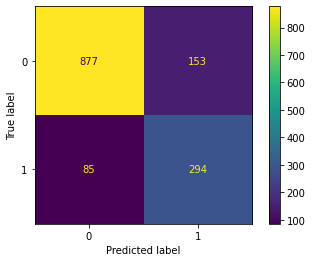

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
c_matrix = confusion_matrix(target_test, pred)
ConfusionMatrixDisplay(c_matrix).plot()

## Feature Importance

Let's dive into feature importance now that we have a fully trained and tested model.

     |████████████████████████████████| 532 kB 16.5 MB/s eta 0:00:01


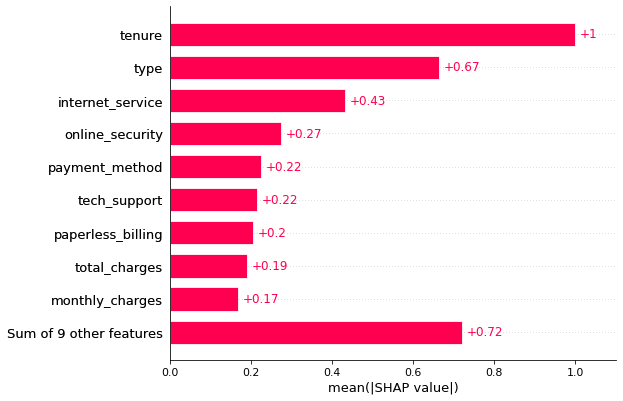

In [88]:
!pip install shap
import shap

explainer = shap.Explainer(model_cb)
shap_values = explainer(x_train)

shap.plots.bar(shap_values)

At a glance, tenure matters the most to the model's prediction, followed by the type of contract and whether or not the customer has internet service. Let's investigate each of these for specifics.

### Tenure

<AxesSubplot:xlabel='churned', ylabel='tenure'>

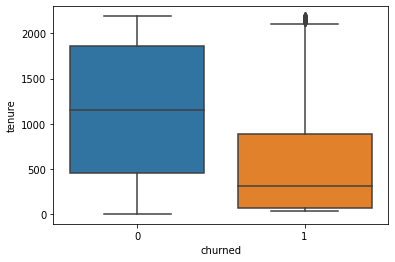

In [89]:
sns.boxplot(data=df, x='churned', y='tenure')

Customers with a longer tenure are less likely to churn. Specifically, around 75% of those who churned had a tenure less than 1000 days.

### Type

<AxesSubplot:xlabel='churned', ylabel='type'>

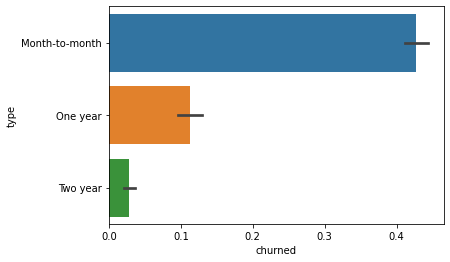

In [90]:
sns.barplot(data=df, x='churned', y='type')

Monthly users churn at a far higher rate than other contracted users.

### Internet Service

<AxesSubplot:xlabel='churned', ylabel='internet_service'>

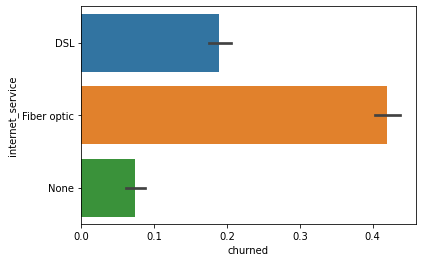

In [91]:
sns.barplot(data=df, x='churned', y='internet_service')

Users with fiber optic internet churn at a far higher rate than users with DSL internet or no internet.

# Conclusion

The final model had a tested AUC-ROC score of 0.90, which indicates a high performance in correctly identifying user churn. The top three factors that the model used to predict churn were tenure, contract type, and internet type. Key identifiers for users about to churn include:

    - shorter duration (<1000 days)
    - month-to-month contracts
    - fiber optic internet service

# Solution Report

## Which steps of the plan were performed and which were skipped?

1. Loading and preprocessing
    - Load csv data into DataFrames
    - Change column names to snake case
    - Update datatypes to correct types
    - Join tables into master dataframe
2. Feature Engineering
    - Combine redundant features
    - Create Boolean target column from churn data
    - Extract specific date information from BeginDate data and find length of tenure
3. Exploratory Data Analysis
    - Look for correlation amongst features
    - Look for correlation between features and target
4. Try machine learning models
    - Split dataset into train/validate/test sets, while balancing classes
    - Further preprocess dataset based on each model's requirements (OHE vs ordinal encoding)
    - Use logistic regression model as sanity check
    - Try gradient boosting, random forest, and another type of model
5. Test final model
    - Test the best performing model on the test set
    - Report tested AUC-ROC and accuracy scores
    - Draw conclusions

I performed all of my loading and initial preprocessing steps. Updating datatypes required me to fill missing values. I also changed yes/no's to 1/0's in relevant columns. 

For feature engineering, I did combine redundant phone service features but did not combine other features that I had initially considered combining. I created a taregt as intended. Initially, I created features from tenure and from the start date - later on I found data leakage, so I removed the start date features and kept only tenure. 

I conducted brief exploration of the data, looking at simple correlations between features and the target. 

For the machine learning phase, I did split up the data, but I did not manually balance the classes, because the scikit-learn models I used all allowed me to easily balance the classes during training. For each model, I did preprocess the data accordingly, and I did first train a logistic regression model to use as a baseline. I did train two gradient boosted models, a random forest, and another type (K Nearest Neighbors).

I tested the best performing model on the test set, which was the CatBoost Classifier. I found the final AUC-ROC/accuracy scores. I looked into the most heavily weighted features, explored to find patterns, and made conclusions based on these features.

## Difficulties that I encountered

The first minor challenge was converting column names from CamelCase to snake_case. This is easy to accomplish manually, but on this project I decided there had to be a better way, so I investigated and found a function from a package that accomplished this quickly.

I initially had changed yes/no's to True/False Bools, which ended up causing inconvenience with the gradient boosting models I chose - I eventually just changed these values to 1/0's to eliminate that issue.

The first and only major issue I ran into was my CatBoost Classifier getting an AUC-ROC score of 0.99 or so, which was unrealistically high. I was confused because my logistic regression and random forest models had performed about as well as expected. Therefore, I attributed the problem to something involving my specific CatBoost preprocessing/training. Nothing that I tweaked in this section changed the outcome, so I went back further in my code to look around. I figured that data leakage had to be the culprit, but I was totally unclear on where/how it was introduced. I experimented with the features I had created, and I found that only using tenure and omitting the other start-date features that I had created fixed the problem. 

## Key steps to solving the task

Distilling the whole process into a few key steps:

    - Defining the problem and outlining a well-defined but flexible plan
    - Preprocessing the csv files into a workable master DataFrame
    - Training and validating a variety of supervised learning models
    - Testing a final chosen model and identifying key features

## Final model

A CatBoost Classifier was used as my final tested model, yielding an AUC-ROC score of 0.90, which exceeds both the minimum requirement of 0.75 and the desired minimum score of 0.88.